# Import Modules

## Standard Packages

In [1]:
import os
import sys
import os.path as path
import psutil
import glob
import random
import numpy as np
import pandas as pd
import xarray as xr
import pickle
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
#plt.style.use('seaborn-white')
from datetime import date, datetime, timedelta, time
from timeit import default_timer as timer
import time

## Scikit-Learn

In [2]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier, MLPRegressor

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, average_precision_score
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_curve, classification_report


## User-Defined Functions

In [3]:
from Extract_DFM_Reanalysis_Data_Helper import *

# Global Start Time and Memory

In [4]:
global_start_time = timer()
process = psutil.Process(os.getpid())
global_initial_memory = process.memory_info().rss

# Variables to be Used for Preparing Train, Test, and Fire Data

## DataSet Defintion

In [5]:
# The current data set params
data_set_count = 8

## Define Model, Label etc.

### Label Type

In [6]:
label_type = 'Regr' # ['bin', 'MC', 'Regr']

In [7]:
FM_hr = 10 # [10, 100]

### Models 

In [8]:
model_considered = 'MLP' # ['RF', SVM', 'MLP']

### Fire of Interest

In [9]:
fire_name = 'Woosley'

## Paths and File Names

#### Global

In [10]:
prepared_data_base_loc = '/p/lustre2/jha3/Wildfire/Wildfire_LDRD_SI/SJSU/02_TrainTestFire_Data_Prepared'
trained_model_base_loc = '/p/lustre2/jha3/Wildfire/Wildfire_LDRD_SI/SJSU/03_Trained_Models'
analysis_data_base_loc = '/p/lustre2/jha3/Wildfire/Wildfire_LDRD_SI/SJSU/04_Analysis'

#### DataSet Specific (Train, Test, Fire Prepared)

In [11]:
prepared_data_set_name = 'data_prepared_%02d'%(data_set_count)

prepared_data_loc = os.path.join(prepared_data_base_loc, prepared_data_set_name)
os.system('mkdir -p %s'%prepared_data_loc)

prepared_data_file_name = '{}.pkl'.format(prepared_data_set_name)

#### DataSet Specific (Trained Model)

In [12]:
trained_model_set_name = 'trained_model_%02d'%(data_set_count)

trained_model_loc = os.path.join(trained_model_base_loc, trained_model_set_name)
os.system('mkdir -p %s'%trained_model_loc)

trained_model_name = '{}_{}_{}.pkl'.format(trained_model_set_name, label_type, model_considered)
trained_model_file = os.path.join(trained_model_loc, trained_model_name)

#### DataSet Specific (Analysis Data)

In [13]:
analysis_set_name = 'analysis_%02d'%(data_set_count)

analysis_loc = os.path.join(analysis_data_base_loc, analysis_set_name, label_type, model_considered)
os.system('mkdir -p %s'%analysis_loc)

0

In [14]:
analysis_loc

'/p/lustre2/jha3/Wildfire/Wildfire_LDRD_SI/SJSU/04_Analysis/analysis_08/Regr/MLP'

# Generate seed for the random number generator

In [15]:
seed = generate_seed()
random_state = init_random_generator(seed)

# Load The The Prepared Data Saved in Pickle File

In [16]:
prepared_data_file_handle = open(os.path.join(prepared_data_loc, prepared_data_file_name), 'rb')
prepared_data = pickle.load(prepared_data_file_handle)
prepared_data_file_handle.close()
print('Read prepared data from "{}" at "{}"'.format(prepared_data_file_name, prepared_data_loc))

Read prepared data from "data_prepared_08.pkl" at "/p/lustre2/jha3/Wildfire/Wildfire_LDRD_SI/SJSU/02_TrainTestFire_Data_Prepared/data_prepared_08"


# Get Features and Labels to Use

In [17]:
prepared_data['tt']['all']
#prepared_data['fire']['Woosley']['identity'].head(5)

,FM_time_ind,FM_ts,his_time_ind,grid_ind,j_ind,i_ind,FM_10hr,FM_100hr,HGT,T2[-12hr],...,PREC[-3hr],SWDOWN[-3hr],UMag10[-12hr],UMag10[-9hr],UMag10[-6hr],UMag10[-3hr],FM_10hr_bin,FM_100hr_bin,FM_10hr_MC,FM_100hr_MC
0,129376,2014-10-04_17,"[129364, 129367, 129370, 129373]",172743,436,87,0.081303,0.060392,1196.704102,290.238007,...,0.0,0.000000,3.370972,3.818593,2.985074,3.766801,1,1,2,2
1,129376,2014-10-04_17,"[129364, 129367, 129370, 129373]",147489,372,177,0.065300,0.054188,1981.272827,288.231506,...,0.0,0.000000,1.033033,2.975315,3.005633,3.430134,1,1,2,1
2,129376,2014-10-04_17,"[129364, 129367, 129370, 129373]",156204,394,180,0.074757,0.077623,1019.257080,292.984131,...,0.0,0.000000,3.522808,4.344636,1.751943,0.227850,1,1,2,2
3,129376,2014-10-04_17,"[129364, 129367, 129370, 129373]",115464,291,228,0.058183,0.054388,1919.916626,288.276031,...,0.0,0.000000,3.381924,2.957719,3.460345,3.436538,1,1,1,1
4,129376,2014-10-04_17,"[129364, 129367, 129370, 129373]",20119,50,319,0.006902,0.026149,1005.895142,294.736145,...,0.0,0.000000,6.540504,7.152994,9.666075,10.145338,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,101661,2011-08-06_22,"[101649, 101652, 101655, 101658]",116113,293,85,0.178441,0.188185,66.710915,285.590149,...,0.0,534.044006,2.688014,2.371523,2.828013,4.081939,0,0,5,5
499996,101661,2011-08-06_22,"[101649, 101652, 101655, 101658]",130960,330,280,0.036267,0.025823,1223.386963,296.904327,...,0.0,969.697937,7.346962,4.317429,4.737289,3.498094,1,1,1,0
499997,101661,2011-08-06_22,"[101649, 101652, 101655, 101658]",128117,323,209,0.074344,0.051710,1503.417847,288.861084,...,0.0,973.866089,3.147550,3.370180,2.061400,3.378033,1,1,2,1
499998,101661,2011-08-06_22,"[101649, 101652, 101655, 101658]",93285,235,225,0.061442,0.054181,424.036285,293.899780,...,0.0,960.523804,2.615936,2.852156,1.677650,3.250591,1,1,2,1


## Get the Headers for Features and Labels

In [18]:
features_to_use = prepared_data['tt']['features'].keys()
if (label_type == 'Regr'):
    label_to_use = 'FM_{}hr'.format(FM_hr)
else:
    label_to_use = 'FM_{}hr_{}'.format(FM_hr, label_type)

In [19]:
label_to_use

'FM_10hr'

## Extract Features and Labels

In [20]:
X_tt     = prepared_data['tt']['features'][features_to_use]
y_tt     = prepared_data['tt']['labels'][label_to_use]
idy_tt   = prepared_data['tt']['identity']

X_fire   = prepared_data['fire'][fire_name]['features'][features_to_use]
y_fire   = prepared_data['fire'][fire_name]['labels'][label_to_use]
idy_fire = prepared_data['fire'][fire_name]['identity']

#all = prepared_data['tt']['all']

In [21]:
y_tt

0         0.081303
1         0.065300
2         0.074757
3         0.058183
4         0.006902
            ...   
499995    0.178441
499996    0.036267
499997    0.074344
499998    0.061442
499999    0.123963
Name: FM_10hr, Length: 500000, dtype: float64

## Scale Features

#### Features for Train/Test

In [22]:
scaler = MinMaxScaler()
scaler.fit(X_tt)
X_tt_scaled = scaler.transform(X_tt)

In [23]:
#X_tt_scaled

#### Features for Fire Data

In [24]:
scaler = MinMaxScaler()
scaler.fit(X_fire)
X_fire_scaled = scaler.transform(X_fire)

In [25]:
#X_fire_scaled.max()

## Train /Test Split

In [26]:
features_train, features_test, labels_train, labels_test = train_test_split(X_tt_scaled, y_tt, test_size=0.2)

# Model

## Define the Model

In [27]:
print ('label_type: {}'.format(label_type))
print ('Model: {}'.format(model_considered))

if (label_type == 'Regr'):
    match model_considered:
        case 'SVM':
            model = SVR(kernel='rbf')
        case 'RF':
            model = RandomForestRegressor(max_depth=2, random_state=0)
        case 'MLP':
            model = MLPRegressor(random_state=1, max_iter=500)
else: # 'bin' or 'MC'
    match model_considered:
        case 'SVM':
            model = SVC(kernel="linear", class_weight = "balanced")
        case 'RF':
            model = RandomForestClassifier(max_depth=2, random_state=0)
        case 'MLP':
            model = MLPClassifier(solver = 'sgd', activation = 'relu', max_iter= 10000, 
                    random_state = 0, hidden_layer_sizes = [15,15,15])


label_type: Regr
Model: MLP


In [28]:
model

MLPRegressor(max_iter=500, random_state=1)

## Train the Model

In [29]:
t0 = time.time()
model.fit(features_train, labels_train)
print ("Training Time:", round(time.time()-t0, 3), "s")

Training Time: 38.241 s


## Save the Model

In [30]:
pickle.dump(model, open(trained_model_file, 'wb'))

## Load the Model

In [31]:
trained_model_file

'/p/lustre2/jha3/Wildfire/Wildfire_LDRD_SI/SJSU/03_Trained_Models/trained_model_08/trained_model_08_Regr_MLP.pkl'

In [32]:
model = pickle.load(open(trained_model_file, 'rb'))

In [33]:
model

MLPRegressor(max_iter=500, random_state=1)

# Prediction with Trained Model

## Prediction on Train Data

In [34]:
t1 = time.time()
labels_pred = model.predict(features_train)
print ("Prediction Time:", round(time.time()-t1, 3), "s")

Prediction Time: 1.02 s


In [35]:
if (label_type == 'bin' or 'label_type' == 'MC'):
    accuracy = accuracy_score(labels_pred, labels_train)
else:
    accuracy = model.score(features_train, labels_train)
conf_mat = None

In [36]:
if (label_type == 'bin'):
    conf_mat = confusion_matrix(labels_train, labels_pred, labels = [0, 1])
    print('Classification Report: \n')
    print(classification_report(labels_train, labels_pred, labels=[0, 1]))
    average_precision = average_precision_score(labels_train, labels_pred)
    print('Average precision-recall score: {0:0.2f}'.format(
          average_precision))
elif (label_type == 'MC'):
    conf_mat = confusion_matrix(labels_train, labels_pred, labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
else:
    print('Confusion Mat is not suitable for label_type: {}'.format(label_type))

print('Accuracy Score: {}'.format(accuracy))
print('Confusion Matrix: \n{}'.format(conf_mat))

Confusion Mat is not suitable for label_type: Regr
Accuracy Score: 0.5783490623271323
Confusion Matrix: 
None


## Prediction on Test Data

In [37]:
t1 = time.time()
labels_pred = model.predict(features_test)
print ("Prediction Time:", round(time.time()-t1, 3), "s")

Prediction Time: 0.22 s


In [38]:
if (label_type == 'bin' or 'label_type' == 'MC'):
    accuracy = accuracy_score(labels_pred, labels_test)
else:
    accuracy = model.score(features_test, labels_test)
conf_mat = None

In [39]:
if (label_type == 'bin'):
    conf_mat = confusion_matrix(labels_test, labels_pred, labels = [0, 1])
    print('Classification Report: \n')
    print(classification_report(labels_test, labels_pred, labels=[0, 1]))
    average_precision = average_precision_score(labels_test, labels_pred)
    print('Average precision-recall score: {0:0.2f}'.format(
          average_precision))
elif (label_type == 'MC'):
    conf_mat = confusion_matrix(labels_test, labels_pred, labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
else:
    print('Confusion Mat is not suitable for label_type: {}'.format(label_type))

print('Accuracy Score: {}'.format(accuracy))
print('Confusion Matrix: \n{}'.format(conf_mat))

Confusion Mat is not suitable for label_type: Regr
Accuracy Score: 0.5704687906138395
Confusion Matrix: 
None


## Prediction on Fire Data

In [40]:
t1 = time.time()
labels_pred = model.predict(X_fire_scaled)
print ("Prediction Time:", round(time.time()-t1, 3), "s")

Prediction Time: 0.28 s


In [41]:
if (label_type == 'bin' or 'label_type' == 'MC'):
    accuracy = accuracy_score(labels_pred, y_fire)
else:
    accuracy = model.score(X_fire_scaled, y_fire)
conf_mat = None

In [42]:
if (label_type == 'bin'):
    conf_mat = confusion_matrix(y_fire, labels_pred, labels = [0, 1])
    print('Classification Report: \n')
    print(classification_report(y_fire, labels_pred, labels=[0, 1]))
    average_precision = average_precision_score(y_fire, labels_pred)
    print('Average precision-recall score: {0:0.2f}'.format(
          average_precision))
elif (label_type == 'MC'):
    conf_mat = confusion_matrix(y_fire, labels_pred, labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
else:
    print('Confusion Mat is not suitable for label_type: {}'.format(label_type))

print('Accuracy Score: {}'.format(accuracy))
print('Confusion Matrix: \n{}'.format(conf_mat))

Confusion Mat is not suitable for label_type: Regr
Accuracy Score: -1.6943737631053337
Confusion Matrix: 
None


## Plot Ground Truth and Prediction of Fire Data

In [43]:
ny, nx = (480, 396)
j_indices = idy_fire['j_ind']
i_indices = idy_fire['i_ind']
ground_truth = y_fire

In [44]:
if label_type == 'Regr':
    ground_truth_mat = np.full((ny,nx), np.nan)
    pred_mat = np.full_like(ground_truth_mat, np.nan )
    error_mat = np.full_like(ground_truth_mat, np.nan)
else:
    ground_truth_mat = np.ones((ny,nx), int)*(-1)
    pred_mat = np.ones_like(ground_truth_mat, int)*(-1)
    error_mat = np.ones_like(ground_truth_mat, int)*(-1)

In [52]:
for j_loc, i_loc, gt_val, pred_val in zip (j_indices, i_indices, ground_truth, labels_pred):
    ground_truth_mat[j_loc][i_loc] = gt_val
    pred_mat[        j_loc][i_loc] = pred_val
    if (label_type == 'bin' or 'label_type' == 'MC'):
        error_mat[       j_loc][i_loc] = (gt_val == pred_val)
    else:
        error_mat[       j_loc][i_loc] = 100.0*(pred_val/gt_val - 1.0)

In [53]:
#error_mat

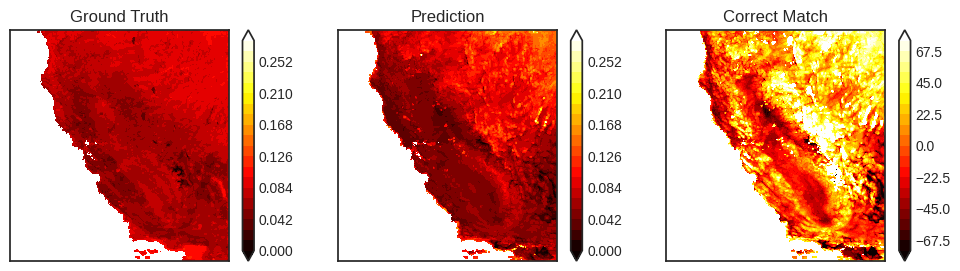

In [57]:
cmap_name = 'hot'
cont_levels = [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
cont_levels = np.linspace(0, 0.28, 21)
cont_levels_err = np.linspace(-75.0, 75.0, 21)
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

x_ind, y_ind = np.meshgrid(range(nx), range(ny))

cont = ax[0].contourf(x_ind, y_ind, ground_truth_mat, levels = cont_levels, cmap=cmap_name, extend='both')
plt.colorbar(cont)
ax[0].set_title('Ground Truth')
ax[0].set_xticks([])
ax[0].set_yticks([])

cont = ax[1].contourf(x_ind, y_ind, pred_mat, levels = cont_levels, cmap=cmap_name, extend='both')
plt.colorbar(cont)
ax[1].set_title('Prediction')
ax[1].set_xticks([])
ax[1].set_yticks([])

cont = ax[2].contourf(x_ind, y_ind, error_mat, levels = cont_levels_err, cmap=cmap_name, extend='both')
plt.colorbar(cont)
ax[2].set_title('Correct Match')
ax[2].set_xticks([])
ax[2].set_yticks([])

filename = trained_model_name.split('.')[0] + '_{}_Fire.png'.format(fire_name)
filedir = analysis_loc
os.system('mkdir -p %s'%filedir)

plt.savefig(os.path.join(filedir, filename), bbox_inches='tight')

# Global End Time and Memory

In [48]:
global_final_memory = processﬁ.memory_info().rss
global_end_time = timer()
global_memory_consumed = global_final_memory - global_initial_memory
print('Total memory consumed: {:.3f} MB'.format(global_memory_consumed/(1024*1024)))
print('Total computing time: {:.3f} s'.format(global_end_time - global_start_time))
print('=========================================================================')
print("SUCCESS: Done Training and Testing of Model")

Total memory consumed: 1243.715 MB
Total computing time: 46.875 s
SUCCESS: Done Training and Testing of Model
